# **CIFAR-10 image classification**

### Load, pre-process and explore data

In [2]:
# Import libraries
import json 
from pprint import pprint
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter

In [46]:
# Define transformation
transform_train_0 = transforms.Compose([
    transforms.ToTensor(),
]) # basic trasformation

transform_train_1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784)),
]) # transformation with normalization

transform_train_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784)),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.3),
    transforms.ColorJitter(),
]) # transformation with normalization & augmentation

transform_train_3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.3),
    transforms.ColorJitter(),
]) # transformation with augmentation

transform_val_0 = transforms.Compose([transforms.ToTensor(),
                                     ])

transform_val_1 = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784)),
                                     ])
# Define batch size
batch_size=32

# Load data
trainset_0 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_0)
train_dataloader_0 = torch.utils.data.DataLoader(trainset_0, batch_size=batch_size , shuffle=True)

trainset_1 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_1)
train_dataloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size , shuffle=True)

trainset_2 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_2)
train_dataloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=batch_size , shuffle=True)

trainset_3 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_3)
train_dataloader_3 = torch.utils.data.DataLoader(trainset_3, batch_size=batch_size , shuffle=True)

valset_0 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val_0)
val_dataloader_0 = torch.utils.data.DataLoader(valset_0, batch_size= batch_size, shuffle=False)

valset_1 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val_1)
val_dataloader_1 = torch.utils.data.DataLoader(valset_1, batch_size= batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [23]:
# Check shape
print("train data shape:", trainset_0.data.shape)
print("test data shape:",trainset_0.data.shape)

train data shape: (50000, 32, 32, 3)
test data shape: (10000, 32, 32, 3)


In [24]:
# Label dictionary
label_dict = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

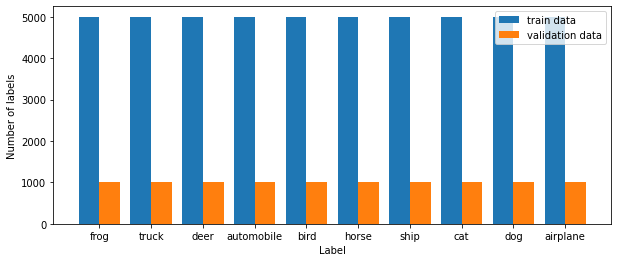

In [25]:
# Label distribution
c_train = Counter(trainset_0.targets)
c_val = Counter(trainset_0.targets)
X = [label_dict[k] for k in c_train.keys()]
X_axis = np.arange(len(X))
plt.figure(figsize=(10,4))
plt.bar(X_axis - 0.2, c_train.values(), 0.4, label = 'train data')
plt.bar(X_axis + 0.2, c_val.values(), 0.4, label = 'validation data')
plt.xticks(X_axis, X)
plt.xlabel("Label")
plt.ylabel("Number of labels")
plt.legend()
plt.show()

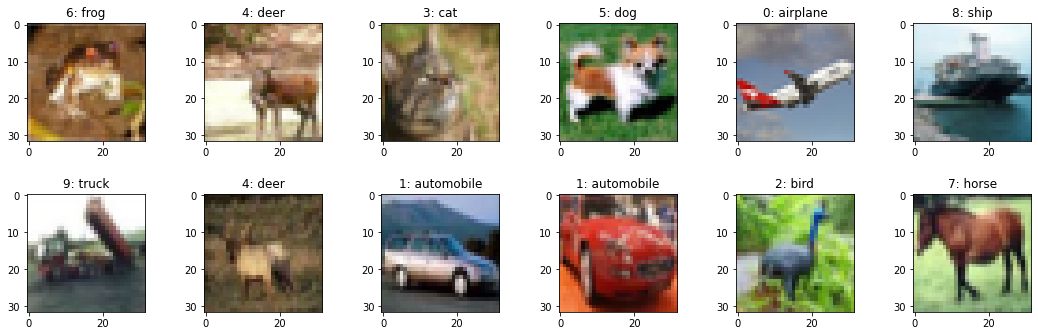

In [26]:
# Plot random images
image_idx = [0,1001,3550,12310,31674,42763,2,3,4,5,6,7]
fig = plt.figure(figsize=(18,6))
fig.subplots_adjust(hspace=0.1, wspace=0.5)

for i in range(len(image_idx)):
  img_index = image_idx[i]
  # Load image at index img_index
  rgb_img = trainset_0.data[img_index]
  rgb_img = rgb_img.astype('float32')    
  rgb_img/= 255.0

  # Plot
  ax = fig.add_subplot(2, 6, i+1)
  ax = plt.imshow(rgb_img)
  ax = plt.title(f'{trainset_0.targets[img_index]}: {label_dict[trainset_0.targets[img_index]]}')

### Set up GPU & functions

In [27]:
# Connect to drive to save models
from google.colab import drive
drive.mount('/content/gdrive')
!pwd

Mounted at /content/gdrive
/content


In [28]:
# Set up GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"Using {device}.")
if gpu_info.find('failed') >= 0:
  if device == "cpu":
    print('Not connected to a GPU')
else:
  if device == "cuda":
    print(gpu_info)

Using cuda.
Mon Jan 30 12:18:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                            

In [29]:
def train_validate_model(train_loader,valid_loader,model,epochs,optimizer, save_pth):
  '''
  Input: train & validation data, model and its parameters, path to save model
  Output: - the model is trained and validated on the provided data
          - training & validation accuracy & loss are recorded and returned as output
  '''
  train_acc = []
  train_loss = []
  val_acc = []
  val_loss = []

  for epoch in range(epochs):
      # Training
      total_train=0
      correct_train = 0
      for i, (images, labels) in enumerate(train_loader):  
          # Move tensors to the configured device
          images = images.to(device)
          labels = labels.to(device)
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # Calculate train accuracy
          _, predicted = torch.max(outputs.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()
          del images, labels, outputs
      # Record accuracy & loss
      train_loss.append(loss.item())
      train_acc.append(100 * correct_train / total_train)
      print ('Epoch [{}/{}], Loss: {:.4f}, Train accuracy: {}' 
                   .format(epoch+1, epochs, loss.item(),100 * correct_train / total_train))
            
      # Validation
      with torch.no_grad():
          correct_val = 0
          total_val = 0
          for images, labels in valid_loader:
              # Move tensors to the configured device
              images = images.to(device)
              labels = labels.to(device)
              # Predict label
              outputs = model(images)
              # Calculate loss & accuracy
              loss=criterion(outputs, labels)
              _, predicted = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted == labels).sum().item()
              del images, labels, outputs
          # Record accuracy & loss
          val_loss.append(loss.item())
          val_acc.append(100 * correct_val / total_val)
          print('Loss: {:.4f}, Validation accuracy: {} %'.format(loss.item(), 100 * correct_val / total_val))
      # Save model by epoch 
      torch.save(model.state_dict(), f'{save_pth}/{epoch+1}epoch.pt')

  return train_acc, train_loss, val_acc, val_loss

In [30]:
def plot_acc_loss(epoch_list, train_acc, train_loss, val_acc, val_loss):
  '''
  Input: list of epoch number, list of training & validation accuracy & loss
  Output: 2 graphs of loss and accuracy by epoch and train/validation
  '''
  f, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 5))
  # Plot loss graph
  ax1.plot(epoch_list, train_loss, label = "Train losses by epoch")
  ax1.plot(epoch_list, val_loss, label = "Validation losses by epoch")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Cross entrophy loss")
  ax1.legend()
  # Plot accuracy graph
  ax2.plot(epoch_list, train_acc, label = "Train accuracy by epoch")
  ax2.plot(epoch_list, val_acc, label = "Validation accuracy by epoch")
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy score")
  ax2.legend()

### 1. VGG16

#### 1.1 Architecture

In [47]:
# Define VGG16 network
class VGG16(nn.Module):
    def __init__(self,num_classes=10):
        super(VGG16, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1*1*512, 4096), # change to adapt to 32x32 image input
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out) # 16x16
        out = self.layer3(out)
        out = self.layer4(out) # 8x8
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out) # 4x4
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out) # 2x2
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out) # 1x1
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

#### 1.2 Basic transformation

In [48]:
# Define model parameters
lr = 0.001
epochs = 40
model = VGG16(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG16'

In [49]:
# Train the model
vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss = train_validate_model(train_dataloader_0,val_dataloader_0,model,epochs,optimizer, save_path)

Epoch [1/40], Loss: 1.0948, Train accuracy: 48.118
Loss: 1.2051, Validation accuracy: 63.62 %
Epoch [2/40], Loss: 0.5714, Train accuracy: 69.72
Loss: 0.8393, Validation accuracy: 72.99 %
Epoch [3/40], Loss: 1.3463, Train accuracy: 77.926
Loss: 0.8113, Validation accuracy: 76.03 %
Epoch [4/40], Loss: 0.5150, Train accuracy: 82.986
Loss: 0.9282, Validation accuracy: 79.0 %
Epoch [5/40], Loss: 0.5152, Train accuracy: 86.462
Loss: 1.0142, Validation accuracy: 80.72 %
Epoch [6/40], Loss: 0.3525, Train accuracy: 89.464
Loss: 0.8369, Validation accuracy: 80.82 %
Epoch [7/40], Loss: 0.7896, Train accuracy: 91.2
Loss: 0.8225, Validation accuracy: 80.86 %
Epoch [8/40], Loss: 0.0500, Train accuracy: 93.394
Loss: 0.8944, Validation accuracy: 81.77 %
Epoch [9/40], Loss: 0.1567, Train accuracy: 94.814
Loss: 1.5541, Validation accuracy: 80.82 %
Epoch [10/40], Loss: 0.5589, Train accuracy: 95.462
Loss: 1.2585, Validation accuracy: 82.12 %
Epoch [11/40], Loss: 0.5326, Train accuracy: 96.222
Loss: 1.603

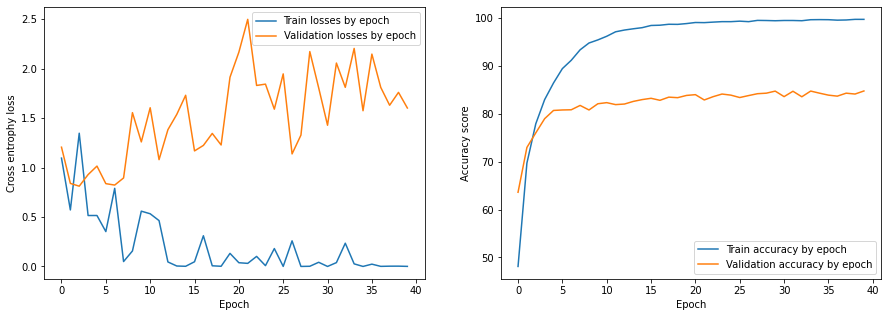

In [50]:
# Plot loss and accuracy plot
epoch_list = []
for epoch in range(epochs):
  epoch_list.append(epoch)

plot_acc_loss(epoch_list, vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss)

#### 1.3 With normalization

In [51]:
# Define model parameters
lr = 0.001
epochs = 40
model = VGG16(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG16'

In [52]:
# Train the model
vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss = train_validate_model(train_dataloader_1,val_dataloader_1,model,epochs,optimizer, save_path)

Epoch [1/40], Loss: 1.3305, Train accuracy: 48.254
Loss: 1.0451, Validation accuracy: 63.07 %
Epoch [2/40], Loss: 1.1556, Train accuracy: 70.1
Loss: 1.0195, Validation accuracy: 73.84 %
Epoch [3/40], Loss: 0.4437, Train accuracy: 77.88
Loss: 0.9857, Validation accuracy: 76.59 %
Epoch [4/40], Loss: 0.7290, Train accuracy: 83.074
Loss: 1.1725, Validation accuracy: 78.6 %
Epoch [5/40], Loss: 0.5819, Train accuracy: 86.564
Loss: 0.8219, Validation accuracy: 80.44 %
Epoch [6/40], Loss: 0.3292, Train accuracy: 89.53
Loss: 1.1848, Validation accuracy: 80.4 %
Epoch [7/40], Loss: 0.3960, Train accuracy: 91.516
Loss: 0.9608, Validation accuracy: 80.37 %
Epoch [8/40], Loss: 0.1651, Train accuracy: 93.138
Loss: 1.0534, Validation accuracy: 81.04 %
Epoch [9/40], Loss: 0.0721, Train accuracy: 94.584
Loss: 0.9230, Validation accuracy: 81.72 %
Epoch [10/40], Loss: 0.0728, Train accuracy: 95.732
Loss: 1.6333, Validation accuracy: 81.88 %
Epoch [11/40], Loss: 0.2938, Train accuracy: 96.29
Loss: 1.6860, 

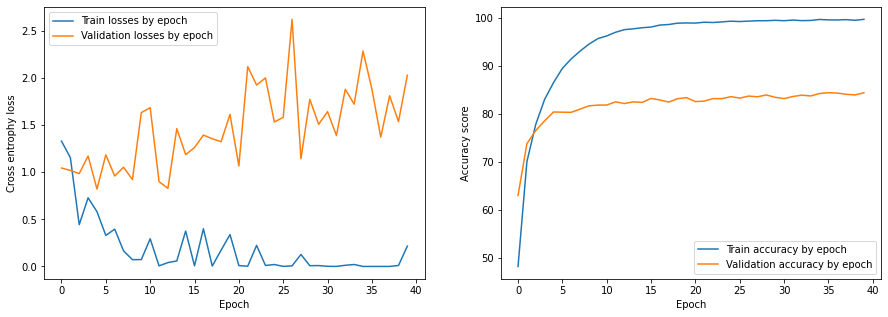

In [53]:
# Plot loss and accuracy plot
epoch_list = []
for epoch in range(epochs):
  epoch_list.append(epoch)

plot_acc_loss(epoch_list, vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss)

#### 1.4 With normalization & augmentation

In [54]:
# Define model parameters
lr = 0.001
epochs = 40
model = VGG16(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG16'

In [55]:
# Train the model
vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss = train_validate_model(train_dataloader_2,val_dataloader_1,model,epochs,optimizer, save_path)

Epoch [1/40], Loss: 1.5949, Train accuracy: 41.904
Loss: 1.2364, Validation accuracy: 58.43 %
Epoch [2/40], Loss: 1.2436, Train accuracy: 61.062
Loss: 0.9243, Validation accuracy: 67.09 %
Epoch [3/40], Loss: 0.7752, Train accuracy: 68.562
Loss: 1.2465, Validation accuracy: 71.22 %
Epoch [4/40], Loss: 0.5966, Train accuracy: 73.022
Loss: 0.9770, Validation accuracy: 75.05 %
Epoch [5/40], Loss: 0.4743, Train accuracy: 76.266
Loss: 0.5167, Validation accuracy: 77.62 %
Epoch [6/40], Loss: 0.4533, Train accuracy: 78.68
Loss: 0.8035, Validation accuracy: 77.52 %
Epoch [7/40], Loss: 0.2875, Train accuracy: 80.784
Loss: 0.4673, Validation accuracy: 79.88 %
Epoch [8/40], Loss: 0.7228, Train accuracy: 82.782
Loss: 0.4802, Validation accuracy: 80.47 %
Epoch [9/40], Loss: 0.7150, Train accuracy: 84.232
Loss: 0.7361, Validation accuracy: 81.4 %
Epoch [10/40], Loss: 0.4312, Train accuracy: 85.422
Loss: 0.6073, Validation accuracy: 81.96 %
Epoch [11/40], Loss: 0.5500, Train accuracy: 86.4
Loss: 0.911

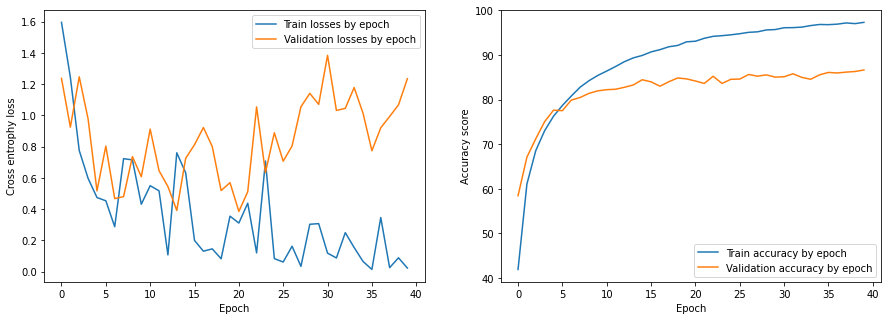

In [56]:
# Plot loss and accuracy plot
epoch_list = []
for epoch in range(epochs):
  epoch_list.append(epoch)

plot_acc_loss(epoch_list, vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss)

#### 1.5 With augmentation

In [57]:
# Define model parameters
lr = 0.001
epochs = 40
model = VGG16(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG16'

In [58]:
# Train the model
vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss = train_validate_model(train_dataloader_3,val_dataloader_0,model,epochs,optimizer, save_path)

Epoch [1/40], Loss: 1.1863, Train accuracy: 41.53
Loss: 1.3669, Validation accuracy: 55.05 %
Epoch [2/40], Loss: 0.9308, Train accuracy: 60.724
Loss: 1.2024, Validation accuracy: 66.4 %
Epoch [3/40], Loss: 0.6970, Train accuracy: 68.726
Loss: 1.1000, Validation accuracy: 71.66 %
Epoch [4/40], Loss: 0.7621, Train accuracy: 73.264
Loss: 0.9660, Validation accuracy: 75.04 %
Epoch [5/40], Loss: 0.2750, Train accuracy: 76.366
Loss: 1.0596, Validation accuracy: 77.61 %
Epoch [6/40], Loss: 0.8071, Train accuracy: 79.186
Loss: 0.9135, Validation accuracy: 79.19 %
Epoch [7/40], Loss: 0.9425, Train accuracy: 81.04
Loss: 1.1022, Validation accuracy: 79.96 %
Epoch [8/40], Loss: 0.3931, Train accuracy: 82.952
Loss: 0.8623, Validation accuracy: 80.39 %
Epoch [9/40], Loss: 0.7980, Train accuracy: 84.332
Loss: 0.9409, Validation accuracy: 81.55 %
Epoch [10/40], Loss: 0.8682, Train accuracy: 85.636
Loss: 0.8367, Validation accuracy: 82.76 %
Epoch [11/40], Loss: 0.3068, Train accuracy: 86.602
Loss: 0.97

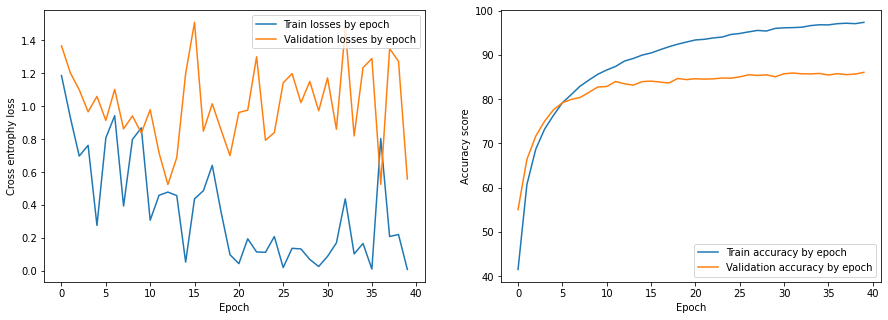

In [59]:
# Plot loss and accuracy plot
epoch_list = []
for epoch in range(epochs):
  epoch_list.append(epoch)

plot_acc_loss(epoch_list, vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss)

#### 1.6 Tune the hyperparameters

In [60]:
# Using SGD and change learning rate
lr_list = [0.1, 0.01, 0.001, 0.0001]
vgg16_train_acc=[]
vgg16_train_loss=[]
vgg16_val_acc=[]
vgg16_val_loss=[]

for lr in lr_list:
  print(f"===== lr = {lr} ====")
  epochs = 60
  model = VGG16(10).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
  save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG16/SGD'
  train_acc, train_loss, val_acc, val_loss = train_validate_model(train_dataloader_2,val_dataloader_1,model,epochs,optimizer, save_path)
  vgg16_train_acc.append(train_acc)
  vgg16_train_loss.append(train_loss)
  vgg16_val_acc.append(val_acc)
  vgg16_val_loss.append(val_loss)

===== lr = 0.1 ====
Epoch [1/60], Loss: 2.2954, Train accuracy: 10.106
Loss: 2.3158, Validation accuracy: 10.02 %
Epoch [2/60], Loss: 2.3204, Train accuracy: 9.72
Loss: 2.3084, Validation accuracy: 9.98 %
Epoch [3/60], Loss: 2.3409, Train accuracy: 9.99
Loss: 2.3202, Validation accuracy: 10.0 %
Epoch [4/60], Loss: 2.2995, Train accuracy: 10.156
Loss: 2.3427, Validation accuracy: 10.0 %
Epoch [5/60], Loss: 2.3323, Train accuracy: 10.14
Loss: 2.3434, Validation accuracy: 10.01 %
Epoch [6/60], Loss: 2.3942, Train accuracy: 10.264
Loss: 2.2861, Validation accuracy: 10.02 %
Epoch [7/60], Loss: 2.3171, Train accuracy: 10.016
Loss: 2.3243, Validation accuracy: 10.0 %
Epoch [8/60], Loss: 2.3331, Train accuracy: 10.006
Loss: 2.3374, Validation accuracy: 10.0 %
Epoch [9/60], Loss: 2.2984, Train accuracy: 9.916
Loss: 2.3805, Validation accuracy: 10.0 %
Epoch [10/60], Loss: 2.3235, Train accuracy: 9.9
Loss: 2.3067, Validation accuracy: 10.01 %
Epoch [11/60], Loss: 2.3279, Train accuracy: 10.148
Lo

KeyboardInterrupt: ignored

In [ ]:
# Accuracy comparision among the learning rates